In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%matplotlib inline
pylab.rcParams['figure.figsize'] = (16, 9)

# save simulation results
import dill
import pickle

# save figures
from scipy.misc import imsave

# plot text on figures
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

# AR1 model using python
#from models.AR1 import ar1_predict, ar1_f, ar1_jac

# data assimilation routines
from algos.EM_EnKS import EnKS, EM_EnKS
from algos.EM_EKS import _EKF, _EKS, EKS, EM_EKS
from algos.LI_EKS import LI_EKF, LI_EKS
from algos.CI_EKS import CI_EKF, CI_EKS
from algos.BI_EKF import BI_EKF
from algos.utils import climat_background, RMSE, gen_truth, gen_obs, cov_prob

Populating the interactive namespace from numpy and matplotlib


/home/ptandeo/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
size_T = [100,1000,10000,100000]
N = 50
N_iter = 100

# initializations
tab_Q_EM        = zeros((N, shape(size_T)[0]))
tab_R_EM        = zeros((N, shape(size_T)[0]))
tab_loglik_EM   = zeros((N, shape(size_T)[0]))
tab_RMSE_EM     = zeros((N, shape(size_T)[0]))
tab_cov_prob_EM = zeros((N, shape(size_T)[0]))
tab_Q_LI        = zeros((N, shape(size_T)[0]))
tab_R_LI        = zeros((N, shape(size_T)[0]))
tab_loglik_LI   = zeros((N, shape(size_T)[0]))
tab_RMSE_LI     = zeros((N, shape(size_T)[0]))
tab_cov_prob_LI = zeros((N, shape(size_T)[0]))

# loop on the size of the sequence
for i_T in range(shape(size_T)[0]):
    
    # loop on the Monte-Carlo simulation
    for i in range(N):
        
        # random number generator
        prng = numpy.random.RandomState(i)

        # dynamical model
        Nx = 1
        f = lambda x: 0.95*x
        jacF = lambda x: array([0.95])

        # observation operator
        No = 1
        h = lambda x: x
        jacH = lambda x: np.eye(Nx)
        H = eye(Nx)

        # size of the sequence
        T = size_T[i_T]

        # generate state
        Q_true = eye(Nx) * .1
        X0_true = array(zeros(Nx))
        X_true = gen_truth(f, X0_true, T+50, Q_true, prng)

        # generate observations
        dt_obs = 1
        R_true = eye(No) * 2
        Yo = gen_obs(h, X_true, R_true, dt_obs, prng)

        # remove first part of the sequence (time to converge to the attractor)
        X_true = X_true[:,50:T+50+1]
        Yo = Yo[:,50:T+50+1]
        
        # background state
        xb, B_tmp = climat_background(X_true)
        B = eye(Nx)*B_tmp

        # parameters
        params = { 'observations'                 : Yo,
                   'background_state'             : xb,
                   'background_covariance'        : B,
                   'model_noise_covariance'       : Q_true,
                   'observation_noise_covariance' : R_true,
                   'model_dynamics'               : f,
                   'model_jacobian'               : jacF,
                   'observation_operator'         : h,
                   'observation_jacobian'         : jacH,
                   'state_size'                   : Nx,
                   'observation_size'             : No,
                   'temporal_window_size'         : size_T[i_T],
                   'true_state'                   : X_true,
                   'inflation_factor'             : 1
                  }

        # function
        res_EKS = EKS(params)

        # extract outputs
        loglik_true = res_EKS['loglikelihood']
        RMSE_true = res_EKS['RMSE']
        cov_prob_true = res_EKS['cov_prob']

        # initial counditions
        Q_init = eye(Nx) # identity matrix for initial Q
        R_init = eye(No) # identity matrix for initial R

        #################### EM ####################
        # parameters
        params = { 'initial_background_state'                 : xb,
                   'initial_background_covariance'            : B,
                   'initial_model_noise_covariance'           : Q_init,
                   'initial_observation_noise_covariance'     : R_init,
                   'model_dynamics'                           : f,
                   'model_jacobian'                           : jacF,
                   'observation_operator'                     : h,
                   'observation_jacobian'                     : jacH,
                   'observations'                             : Yo,
                   'nb_EM_iterations'                         : N_iter,
                   'true_state'                               : X_true,
                   'state_size'                               : Nx,
                   'observation_size'                         : No,
                   'temporal_window_size'                     : size_T[i_T],
                   'model_noise_covariance_structure'         : 'full', # Q and R are full
                   #'model_noise_covariance_matrix_template'   : eye(Nx,Nx), # Q is constant diagonal
                   'is_model_noise_covariance_estimated'      : True,
                   'is_observation_noise_covariance_estimated': True,
                   'is_background_estimated'                  : True, ### IMPORTANT
                   'inflation_factor'                         : 1}

        # function
        res_EM_EKS = EM_EKS(params)

        # outputs
        tab_Q_EM[i,i_T]        = res_EM_EKS['EM_model_noise_covariance'][0,0,-1]
        tab_R_EM[i,i_T]        = res_EM_EKS['EM_observation_noise_covariance'][0,0,-1]
        tab_loglik_EM[i,i_T]   = res_EM_EKS['loglikelihood'][-1]
        tab_RMSE_EM[i,i_T]     = res_EM_EKS['RMSE'][-1]
        tab_cov_prob_EM[i,i_T] = res_EM_EKS['cov_prob'][-1]
        #################### EM ####################

        #################### LI ####################
        # parameters
        params = { 'initial_background_state'                 : xb,
                   'initial_background_covariance'            : B,
                   'initial_model_noise_covariance'           : Q_init,
                   'initial_observation_noise_covariance'     : R_init,
                   'model_dynamics'                           : f,
                   'model_jacobian'                           : jacF,
                   'observation_operator'                     : h,
                   'observation_jacobian'                     : jacH,
                   'observations'                             : Yo,
                   'nb_iterations'                            : N_iter,
                   'true_state'                               : X_true,
                   'state_size'                               : Nx,
                   'observation_size'                         : No,
                   'temporal_window_size'                     : size_T[i_T],
                   'model_noise_covariance_structure'         : 'full', # Q and R are full
                   'inflation_factor'                         : 1,
                   'adaptive_parameter'                       : 10*size_T[i_T]
        }

        # function
        res_LI_EKS = LI_EKS(params)

        # outputs
        tab_Q_LI[i,i_T]        = res_LI_EKS['LI_model_noise_covariance'][0,0,-1]
        tab_R_LI[i,i_T]        = res_LI_EKS['LI_observation_noise_covariance'][0,0,-1]
        tab_loglik_LI[i,i_T]   = res_LI_EKS['loglikelihood'][-1]
        tab_RMSE_LI[i,i_T]     = res_LI_EKS['RMSE'][-1]
        tab_cov_prob_LI[i,i_T] = res_LI_EKS['cov_prob'][-1]
        #################### LI ####################
    
# stock results
res_EM_LI_EKS_AR1_varying_T = {
    'tab_Q_EM'        : tab_Q_EM,
    'tab_R_EM'        : tab_R_EM,
    'tab_loglik_EM'   : tab_loglik_EM,
    'tab_RMSE_EM'     : tab_RMSE_EM,
    'tab_cov_prob_EM' : tab_cov_prob_EM,
    'tab_Q_LI'        : tab_Q_LI,
    'tab_R_LI'        : tab_R_LI,
    'tab_loglik_LI'   : tab_loglik_LI,
    'tab_RMSE_LI'     : tab_RMSE_LI,
    'tab_cov_prob_LI' : tab_cov_prob_LI
}

# store simulation results
#dill.dump(res_EM_LI_EKS_AR1_varying_T, open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_LI_EKS_AR1_varying_T.pkl', 'wb'))

 25%|██▌       | 25/100 [00:00<00:01, 48.28it/s]/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/utils.py:46: RuntimeWarning: invalid value encountered in sqrt
  cov_prob += sum((np.squeeze(Xs[i_n,:]) - 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) <= X_true[i_n,:]) & (np.squeeze(Xs[i_n,:]) + 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) >= X_true[i_n,:])) / T
/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/utils.py:46: RuntimeWarning: invalid value encountered in less_equal
  cov_prob += sum((np.squeeze(Xs[i_n,:]) - 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) <= X_true[i_n,:]) & (np.squeeze(Xs[i_n,:]) + 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) >= X_true[i_n,:])) / T
/home/ptandeo/Dropbox/Documents/Codes/Python/CEDA/algos/utils.py:46: RuntimeWarning: invalid value encountered in greater_equal
  cov_prob += sum((np.squeeze(Xs[i_n,:]) - 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) <= X_true[i_n,:]) & (np.squeeze(Xs[i_n,:]) + 1.96 * np.sqrt(np.squeeze(Ps[i_n,i_n,:])) >= X_true[i_n,:]))

100%|██████████| 100/100 [34:03<00:00, 20.43s/it]


100%|██████████| 100/100 [33:43<00:00, 20.24s/it]


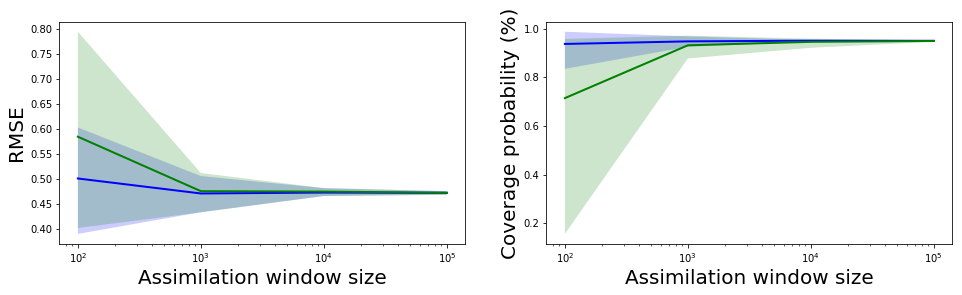

In [3]:
# load simulation results
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_LI_EKS_AR1_varying_T.pkl', 'rb') as in_strm:
    res_EM_LI_EKS_AR1_varying_T = dill.load(in_strm)

size_T = [100,1000,10000,100000]
    
def plot_CI_plot_log(x_axis, mean_ci, lower_ci, upper_ci, color, alpha_val):
    semilogx(x_axis, mean_ci, color, linewidth=2)
    fill_between(x_axis, lower_ci, upper_ci, facecolor=color, alpha=alpha_val)
    
# plot confidence intervals
alpha = 0.2
subplot(2,2,3)
plot_CI_plot_log(size_T, mean(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_EM'], 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_EM'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_EM'], 97.5, 0), 'blue', alpha)
plot_CI_plot_log(size_T, mean(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_LI'], 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_LI'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_LI'], 97.5, 0), 'green', alpha)
#plot((0,shape(size_T)[0]),(trace(Q_true)/Nx,trace(Q_true)/Nx),'--k', linewidth=2)
xlabel('Assimilation window size', fontsize=20)
ylabel('RMSE', fontsize=20)
#ylim([-1,9])
subplot(2,2,4)
plot_CI_plot_log(size_T, mean(res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_EM'], 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_EM'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_EM'], 97.5, 0), 'blue', alpha)
plot_CI_plot_log(size_T, mean(res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_LI'], 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_LI'], 2.5, 0),\
             percentile(res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_LI'], 97.5, 0), 'green', alpha)
#plot((0,N_iter),(trace(R_true)/No,trace(R_true)/No),'--k')
xlabel('Assimilation window size', fontsize=20)
ylabel('Coverage probability (%)', fontsize=20)
#ylim([-1,9])

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/comparison_EM_LI_AR1_varying_T_CI.png', bbox_inches='tight')

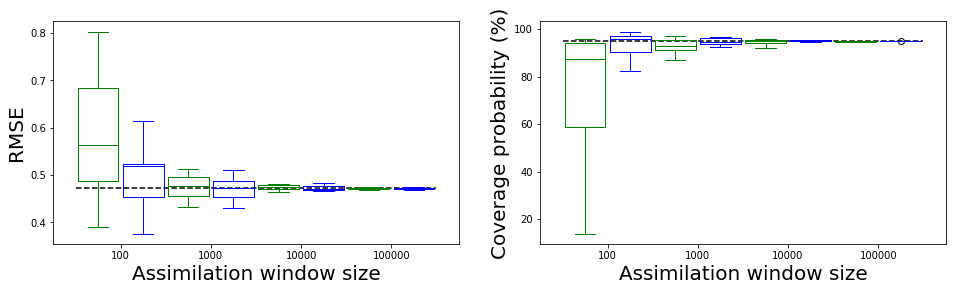

In [5]:
# load simulation results
with open('/home/ptandeo/Dropbox/Documents/Data/CEDA_review/res_EM_LI_EKS_AR1_varying_T.pkl', 'rb') as in_strm:
    res_EM_LI_EKS_AR1_varying_T = dill.load(in_strm)

def set_box_color(bp, color):
    setp(bp['boxes'], color=color)
    setp(bp['whiskers'], color=color)
    setp(bp['caps'], color=color)
    setp(bp['medians'], color=color)
    
size_T = [100,1000,10000,100000]

subplot(2,2,3)
plot([0.5, 4.5], [0.4717, 0.4717],'--k')
bp1 = boxplot(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_EM'], positions=array([1, 2, 3, 4])+0.25)
set_box_color(bp1, 'b')
bp2 = boxplot(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_LI'], positions=array([1, 2, 3, 4])-0.25)
set_box_color(bp2, 'g')
xticks([1, 2, 3, 4], ['100', '1000', '10000', '100000'])
xlabel('Assimilation window size', fontsize=20)
ylabel('RMSE', fontsize=20)
xlim(0.25, 4.75)

subplot(2,2,4)
plot([0.5, 4.5], [95, 95],'--k')
bp1 = boxplot(100*res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_EM'], positions=array([1, 2, 3, 4])+0.25)
set_box_color(bp1, 'b')
bp2 = boxplot(100*res_EM_LI_EKS_AR1_varying_T['tab_cov_prob_LI'], positions=array([1, 2, 3, 4])-0.25)
set_box_color(bp2, 'g')
xticks([1, 2, 3, 4], ['100', '1000', '10000', '100000'])
xlabel('Assimilation window size', fontsize=20)
ylabel('Coverage probability (%)', fontsize=20)
xlim(0.25, 4.75)

# save figure
savefig('/home/ptandeo/Dropbox/Documents/Figures/CEDA_review/comparison_EM_LI_AR1_varying_T_boxplot.png', bbox_inches='tight')

In [6]:
print(res_EM_LI_EKS_AR1_varying_T['tab_RMSE_EM'].shape)

(10, 4)
